# zDCF analysis

In this notebook, we perform an example of complete zDCF analysis. We focus on the case of study of the BL Lacertae radiative emission in the optical R-band and in high-energy (HE; $100\text{MeV}<E<100\text{GeV}$) $\gamma$ rays.

## zDCF

The zDCF computation is performed with a personal implementation of the zDCF algorithm described in Alexander T., "Improved AGN light curve analysis with the z-transformed discrete correlation function", 2013 [https://arxiv.org/abs/1302.1508].

## Light-curve simulations
The light-curve simulations are performed using the method described in Emmanoulopoulos D. et al. 2013, *Monthly Notices of the Royal Astronomical Society*, Volume 433, Issue 2, Pages 907–927 [https://academic.oup.com/mnras/article/433/2/907/1746942].

The lightcurve simulation method was implemented by Sam Connolly in the DELCgen package, available at https://github.com/samconnolly/DELightcurveSimulation. Here we use DELCgen3, which is a Python 3 version of the code, available at https://github.com/cerasole/DELightcurveSimulation.

In the notebook `Analysis_OpticalLC_Simulations` (`Analysis_HEgammaLC_Simulations`), we studied the properties of the optical R-band long-term 2002-2013 (high-energy $\gamma$-ray _Fermi_-LAT) light-curve of BL Lacertae, with the aim of simulating light-curves having the same flux probability density function (PDF) and same power spectral density (PSD) as the observed one. The data files are not included in this repository, they are to be downloaded from the corresponsing servers.
- The optical R-band BL Lacertae light-curve from 2002 to 2013 is publicly available at [https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/620/A185]. 
- The _Fermi_-LAT light-curve of BL Lacertae is publicly available at [https://fermi.gsfc.nasa.gov/ssc/data/access/lat/LightCurveRepository/source.html?source_name=4FGL_J2202.7+4216].



References:
- **Nilsson et al., A&A 620, A185 (2018) paper, entitled "Long-term optical monitoring of TeV emitting Blazars I. Data analysis. (2018)"** [https://www.aanda.org/articles/aa/full_html/2018/12/aa33621-18/aa33621-18.html]
- **S. Abdollahi et al. 2023, "The Fermi-LAT Lightcurve Repository", The Astrophysical Journal Supplement Series (ApJS), Volume 265, Number 2, 31** [https://www.aanda.org/articles/aa/full_html/2018/12/aa33621-18/aa33621-18.html]


In [1]:
### Basic imports
import os, sys
import numpy as np
import pandas as pd
import time, datetime
from astropy.time import Time
import astropy.units as u
import scipy.stats as st
from scipy.special import erf
import matplotlib.pyplot as plt

### zDCF
sys.path.append("../../zDCF/")
from zDCF import Single, Couple

### DELCgen3
sys.path.append("../../DELCgen3/")
from DELCgen3 import Lightcurve, OptBins, Mixture_Dist, BendingPL, PL_no_offset, PL_with_offset, Simulate_TK_Lightcurve, Simulate_DE_Lightcurve

# Style
fontsize = 16
plt.rc("font", family = "Dejavu Sans", weight = "normal", size = fontsize)

### Load the optical light-curve into a Single object

In [2]:
filename = "../../Data/Nilson_et_al_2018_AA_620_A185/lc/BL_Lac.dat"

def get_optical_data(filename):
    jd, m_obs, m_obs_err = np.loadtxt(filename, unpack = True, usecols = (1, 2, 3))
    # Magnitude-to-flux conversion
    reference_R_flux = 3080 * u.Unit("Jy")
    factor = 10**(-0.4)
    # Parameters for corrections for Galactic extinction and host-galaxy contribution, from https://academic.oup.com/mnras/article/436/2/1530/1138672
    A_R, A_R_err = 0.88, 0.01                          # Galactic extinction in R-band
    host_galaxy_correction = 2.54 * u.Unit("mJy")      # 
    #
    mjd = jd - 2400000.5
    m_intr = m_obs - A_R                               # Galactic extinction correction
    m_intr_err = np.sqrt( m_obs_err**2 + A_R_err**2 )
    flux = reference_R_flux * np.power(factor, m_intr)
    flux_max = reference_R_flux * np.power(factor, m_intr - m_intr_err)
    flux_min = reference_R_flux * np.power(factor, m_intr + m_intr_err)
    flux_err = (flux_max - flux_min) / 2
    flux = flux - host_galaxy_correction               # Host galaxy correction
    return mjd, flux, flux_err

mjd_optical, flux_optical, flux_err_optical = get_optical_data(filename)

In [3]:
lc1 = Single()
lc1.set_LC(
    name = "Optical_LC_BL_Lacertae",
    data = {
        "MJD"  :mjd_optical,
        "y"    :flux_optical.to_value("mJy"),
        "yerr" :flux_err_optical.to_value("mJy"),
    }
)

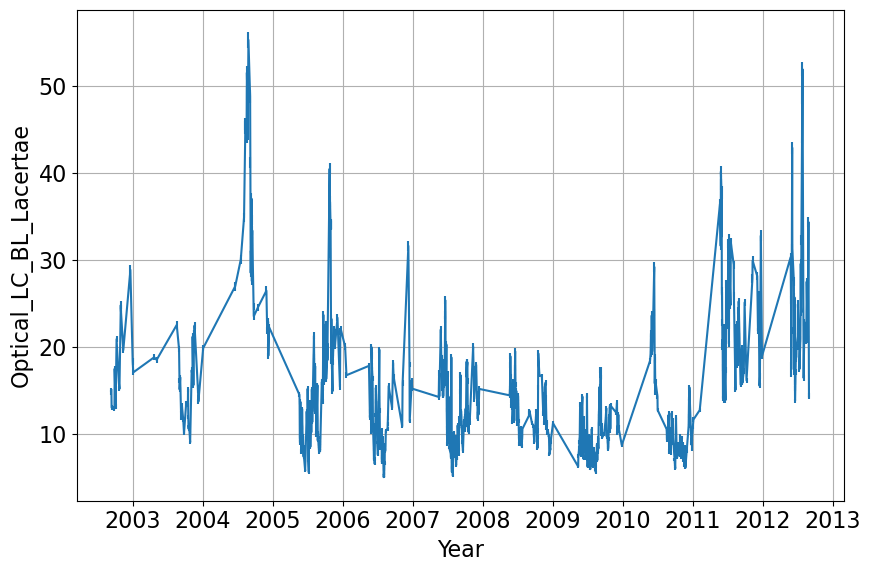

In [4]:
fig, ax = lc1.plot_LC();

### Load the gamma-ray light-curve into a Single object

In [5]:
filename = "../../Data/4FGL_J2202.7+4216_daily_02_11_2024.csv"

def get_FermiLAT_data (filename, TS_cut = 4):
    data = pd.read_csv(filename)
    uplims = data["TS"] < TS_cut
    mjd = data["Julian Date"][~uplims].to_numpy() - 2400000.5
    flux = data["Photon Flux [0.1-100 GeV](photons cm-2 s-1)"][~uplims].to_numpy().astype("float32") * u.Unit("cm-2 s-1")
    flux_err = data["Photon Flux Error(photons cm-2 s-1)"][~uplims].to_numpy().astype("float32") * u.Unit("cm-2 s-1")
    return mjd, flux, flux_err

mjd_gamma, flux_gamma, flux_err_gamma = get_FermiLAT_data(filename)

In [6]:
lc2 = Single()
lc2.set_LC(
    name = "Gamma_LC_BL_Lacertae",
    data = {
        "MJD"  :mjd_gamma,
        "y"    :flux_gamma.to_value("1e-6 cm-2 s-1"),
        "yerr" :flux_err_gamma.to_value("1e-6 cm-2 s-1"),
    }
)

In [7]:
lc2.dict

{'name': 'Gamma_LC_BL_Lacertae',
 'data': {'MJD': array([54684.5      , 54687.5      , 54690.5      , ..., 60606.4999537,
         60609.4999537, 60612.4999537]),
  'y': array([0.0918    , 0.0911    , 0.0987    , ..., 0.47700003, 0.912     ,
         1.0400001 ], dtype=float32),
  'yerr': array([0.041 , 0.0353, 0.0397, ..., 0.071 , 0.087 , 0.09  ], dtype=float32),
  'Dates': array([datetime.datetime(2008, 8, 6, 12, 0),
         datetime.datetime(2008, 8, 9, 12, 0),
         datetime.datetime(2008, 8, 12, 12, 0), ...,
         datetime.datetime(2024, 10, 23, 11, 59, 55, 999981),
         datetime.datetime(2024, 10, 26, 11, 59, 55, 999981),
         datetime.datetime(2024, 10, 29, 11, 59, 55, 999981)], dtype=object)}}

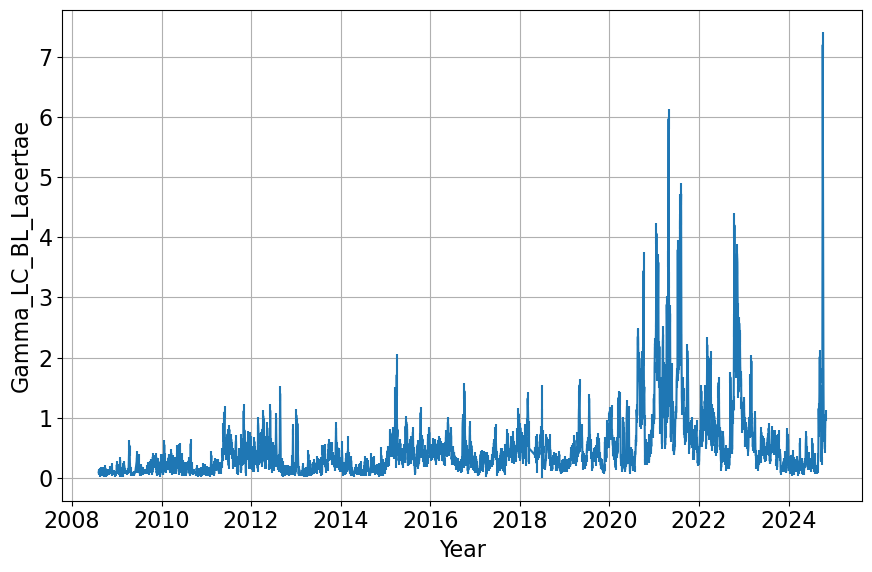

In [8]:
lc2.plot_LC();

### Define the Couple object

In [9]:
couple = Couple()
couple.LC1 = lc1
couple.LC2 = lc2

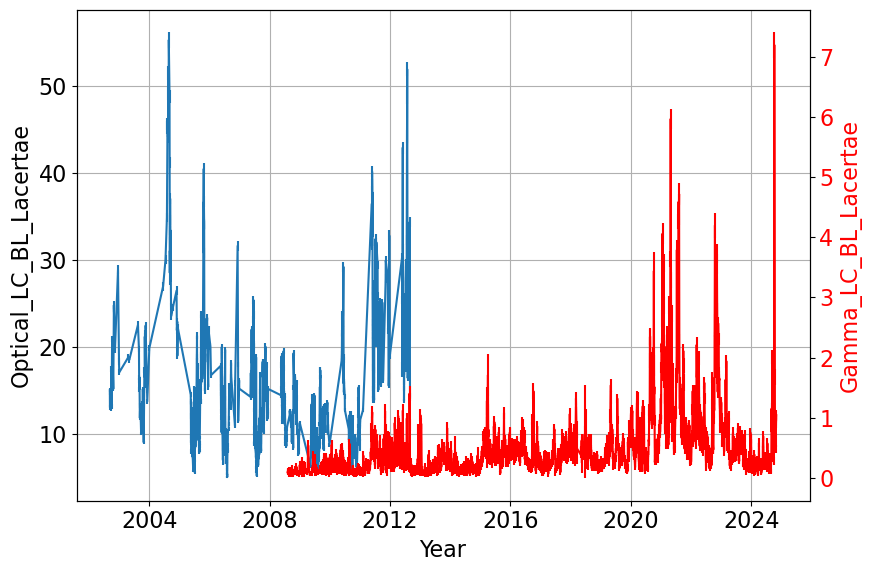

In [10]:
couple.plot_LCs();

### Compute the zDCF

In [11]:
couple.perform_zDCF_analysis?

It is possible to compute it on a custom time grid, via 
- setting the `equal_population_binning` argument to `False`
- setting the `bins` argument.

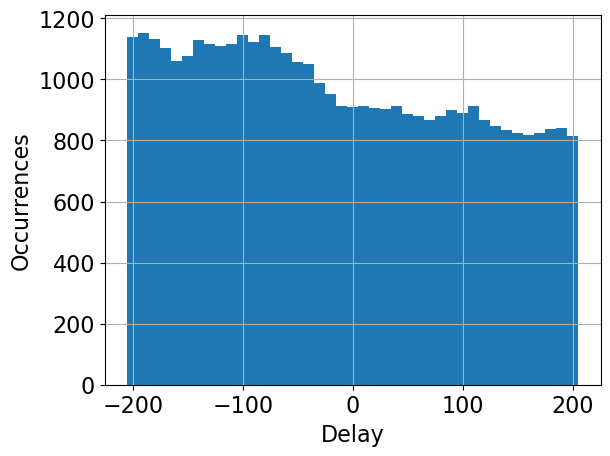


The point of maximum anticorrelation, i.e. the point with lowest zDCF, is found at 
 - delay = -200.00 days,
 - corresponding zDCF = 0.06 +/- 0.01.

The point of maximum correlation, i.e. the point with highest zDCF, is found at 
 - delay = 0.00 days,
 - corresponding zDCF = 0.83 +/- 0.01


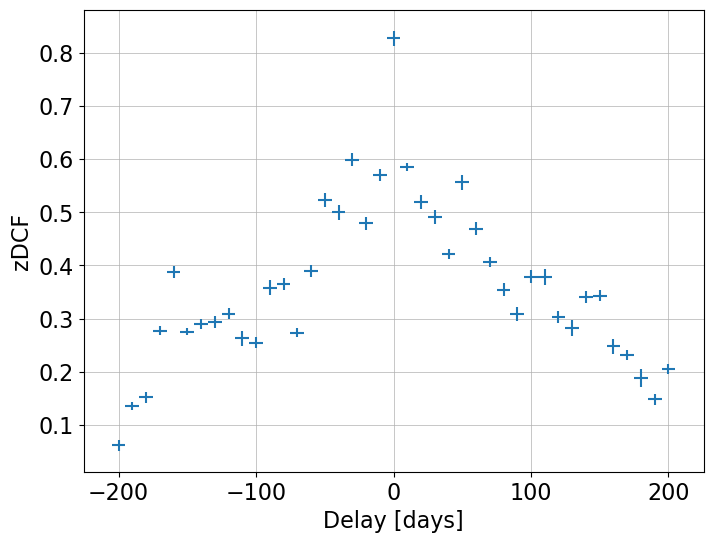

In [12]:
couple.perform_zDCF_analysis(
    nMCs = 20,
    equal_population_binning = False,
    bins = np.arange(-205, 206, 10),
    show_plot=True,
);

In [13]:
output_dir = "./zDCF_analysis/"
os.system("mkdir -p %s" % output_dir)

couple.write_zDCF_result_to_file(
    filename = "zDCF_true_LCs.txt",
    output_dir= output_dir,
)

Successfully saved file ./zDCF_analysis/zDCF_true_LCs.txt!


In [14]:
couple.zDCF

{'delay': array([-200., -190., -180., -170., -160., -150., -140., -130., -120.,
        -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,
         -20.,  -10.,    0.,   10.,   20.,   30.,   40.,   50.,   60.,
          70.,   80.,   90.,  100.,  110.,  120.,  130.,  140.,  150.,
         160.,  170.,  180.,  190.,  200.]),
 'delay_err': array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5.]),
 'zDCF': array([0.06207758, 0.13656012, 0.15221687, 0.27752241, 0.38790021,
        0.27583262, 0.29061656, 0.29347676, 0.3092944 , 0.26300871,
        0.25497057, 0.35795404, 0.36524258, 0.27375749, 0.3899559 ,
        0.52325395, 0.49982484, 0.59897289, 0.47946392, 0.57035782,
        0.8268295 , 0.58480928, 0.51971721, 0.49053678, 0.42149758,
        0.55626776, 0.46935058, 0.4070964 , 0.35481248, 0.30882673,
        0.37862524, 0.37841512, 0.30332499,

## Light-curve simulations for zDCF significance analysis

Here, we use the results of the two notebooks `Analysis_OpticalLC_Simulations` and `Analysis_HEgammaLC_Simulations`.

In [15]:
simulation_setup = {
    "LC1":{
        "TrueLC"   : couple.LC1,
        "PDFmodel" : Mixture_Dist(
            functions = [st.gamma,st.lognorm],
            n_args = [3, 3],
            frozen = [[[2], [3]], [[2], [3]]],  ### here we fix the loc arguments of the gamma and lognorm to 3
        ),
        "PDFparams": [3.2813, 3.7181, 0.2026, 5.9359, 1.3895, 0.2674],
        "PSDmodel" :PL_no_offset,
        "PSDparams":[0.0084, 1.2575],
        "tbin"     :1,
    },
    "LC2":{
        "TrueLC"   : couple.LC2,
        "PDFmodel" : Mixture_Dist(
            functions = [st.lognorm],
            n_args = [3],
            frozen = False,
        ),
        "PDFparams":[0.9, 0.0, 0.3, 1.0],
        "PSDmodel" :PL_no_offset,
        "PSDparams":[0.0641, 1.0679],
        "tbin"     :3,
    }
}

In [41]:
lcs = list(simulation_setup.keys())
show_plot = False

output_dir = "./zDCF_analysis/fake_LCs/"
os.system("mkdir -p %s" % output_dir)

t0 = t1_ = time.time()

for i in range(100, 1000):
    print ("### Generating lightcurves number %d" % (i))
    fake_singles = []
    for lc in lcs:
        LClength = int(
            (
                np.max(simulation_setup[lc]["TrueLC"].dict["data"]["MJD"]) 
                - np.min(simulation_setup[lc]["TrueLC"].dict["data"]["MJD"])
            ) / simulation_setup[lc]["tbin"]
        )
        fake_LC = Simulate_DE_Lightcurve(
            PSDmodel  = simulation_setup[lc]["PSDmodel"], 
            PSDparams = simulation_setup[lc]["PSDparams"],
            PDFmodel  = simulation_setup[lc]["PDFmodel"],
            PDFparams = simulation_setup[lc]["PDFparams"],
            tbin      = simulation_setup[lc]["tbin"],
            LClength  = LClength,
        )

        daily_time = fake_LC.time.astype("float64") + np.min(simulation_setup[lc]["TrueLC"].dict["data"]["MJD"])
        daily_flux = fake_LC.flux
        fake_flux = np.interp(simulation_setup[lc]["TrueLC"].dict["data"]["MJD"], daily_time, daily_flux)
        fake_single = Single()
        fake_single.set_LC(
            name = simulation_setup[lc]["TrueLC"].dict["name"],
            data = {
                "MJD"  :simulation_setup[lc]["TrueLC"].dict["data"]["MJD"],
                "y"    :fake_flux,
                "yerr" :(
                    fake_flux 
                    * np.mean(
                        simulation_setup[lc]["TrueLC"].dict["data"]["yerr"] 
                        / simulation_setup[lc]["TrueLC"].dict["data"]["y"]
                    )
                ),
            }
        )
        fake_singles.append(fake_single)
        
    fake_couple = Couple()
    fake_couple.LC1 = fake_singles[0]
    fake_couple.LC2 = fake_singles[1]
    if show_plot:
        fake_couple.plot_LCs()
        
    fake_couple.perform_zDCF_analysis(
        nMCs = 20,
        equal_population_binning = False,
        bins = np.arange(-205, 206, 10),
        show_plot=show_plot
    )
    fake_couple.write_zDCF_result_to_file(
        filename   = "zDCF_fake_LCs_%06d.txt" % i,
        output_dir = output_dir,
    )
    
    t1 = time.time()
    print ("Elapsed time: %.3f s (Total = %.3f s)" % (t1 - t1_, t1 - t0))
    t1_ = time.time()

### Generating lightcurves number 100
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000100.txt!
Elapsed time: 3.094 s (Total = 3.094 s)
### Generating lightcurves number 101
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000101.txt!
Elapsed time: 3.511 s (Total = 6.605 s)
### Generating lightcurves number 102
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000102.txt!
Elapsed time: 3.240 s (Total = 9.845 s)
### Generating lightcurves number 103
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000103.txt!
Elapsed time: 3.113 s (Total = 12.958 s)
### Generating lightcurves number 104
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000104.txt!
Elapsed time: 3.118 s (Total = 16.076 s)
### Generating lightcurves number 105
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000105.txt!
Elapsed time: 2.931 s (Total = 19.007 s)
### Generating lightcurves number 106
Successfully saved file ./zDCF_analysis/f

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000153.txt!
Elapsed time: 3.439 s (Total = 173.515 s)
### Generating lightcurves number 154
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000154.txt!
Elapsed time: 3.288 s (Total = 176.802 s)
### Generating lightcurves number 155
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000155.txt!
Elapsed time: 3.428 s (Total = 180.231 s)
### Generating lightcurves number 156
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000156.txt!
Elapsed time: 3.210 s (Total = 183.441 s)
### Generating lightcurves number 157
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000157.txt!
Elapsed time: 3.082 s (Total = 186.523 s)
### Generating lightcurves number 158
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000158.txt!
Elapsed time: 3.460 s (Total = 189.983 s)
### Generating lightcurves number 159
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000159.

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000206.txt!
Elapsed time: 2.150 s (Total = 300.245 s)
### Generating lightcurves number 207
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000207.txt!
Elapsed time: 2.342 s (Total = 302.587 s)
### Generating lightcurves number 208
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000208.txt!
Elapsed time: 2.412 s (Total = 304.999 s)
### Generating lightcurves number 209
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000209.txt!
Elapsed time: 2.150 s (Total = 307.149 s)
### Generating lightcurves number 210
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000210.txt!
Elapsed time: 2.354 s (Total = 309.503 s)
### Generating lightcurves number 211
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000211.txt!
Elapsed time: 2.129 s (Total = 311.632 s)
### Generating lightcurves number 212
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000212.

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000259.txt!
Elapsed time: 2.378 s (Total = 420.492 s)
### Generating lightcurves number 260
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000260.txt!
Elapsed time: 7.691 s (Total = 428.184 s)
### Generating lightcurves number 261
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000261.txt!
Elapsed time: 5.342 s (Total = 433.526 s)
### Generating lightcurves number 262
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000262.txt!
Elapsed time: 3.831 s (Total = 437.357 s)
### Generating lightcurves number 263
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000263.txt!
Elapsed time: 4.803 s (Total = 442.160 s)
### Generating lightcurves number 264
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000264.txt!
Elapsed time: 3.449 s (Total = 445.608 s)
### Generating lightcurves number 265
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000265.

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000312.txt!
Elapsed time: 2.202 s (Total = 588.442 s)
### Generating lightcurves number 313
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000313.txt!
Elapsed time: 2.179 s (Total = 590.620 s)
### Generating lightcurves number 314
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000314.txt!
Elapsed time: 2.229 s (Total = 592.849 s)
### Generating lightcurves number 315
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000315.txt!
Elapsed time: 2.258 s (Total = 595.107 s)
### Generating lightcurves number 316
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000316.txt!
Elapsed time: 2.217 s (Total = 597.324 s)
### Generating lightcurves number 317
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000317.txt!
Elapsed time: 2.261 s (Total = 599.585 s)
### Generating lightcurves number 318
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000318.

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000365.txt!
Elapsed time: 2.241 s (Total = 726.049 s)
### Generating lightcurves number 366
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000366.txt!
Elapsed time: 2.102 s (Total = 728.151 s)
### Generating lightcurves number 367
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000367.txt!
Elapsed time: 2.209 s (Total = 730.360 s)
### Generating lightcurves number 368
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000368.txt!
Elapsed time: 2.125 s (Total = 732.485 s)
### Generating lightcurves number 369
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000369.txt!
Elapsed time: 2.015 s (Total = 734.500 s)
### Generating lightcurves number 370
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000370.txt!
Elapsed time: 2.198 s (Total = 736.698 s)
### Generating lightcurves number 371
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000371.

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000418.txt!
Elapsed time: 2.246 s (Total = 865.574 s)
### Generating lightcurves number 419
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000419.txt!
Elapsed time: 2.133 s (Total = 867.707 s)
### Generating lightcurves number 420
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000420.txt!
Elapsed time: 2.192 s (Total = 869.899 s)
### Generating lightcurves number 421
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000421.txt!
Elapsed time: 2.564 s (Total = 872.462 s)
### Generating lightcurves number 422
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000422.txt!
Elapsed time: 2.473 s (Total = 874.935 s)
### Generating lightcurves number 423
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000423.txt!
Elapsed time: 2.401 s (Total = 877.337 s)
### Generating lightcurves number 424
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000424.

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000471.txt!
Elapsed time: 2.249 s (Total = 1000.999 s)
### Generating lightcurves number 472
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000472.txt!
Elapsed time: 2.341 s (Total = 1003.339 s)
### Generating lightcurves number 473
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000473.txt!
Elapsed time: 2.327 s (Total = 1005.667 s)
### Generating lightcurves number 474
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000474.txt!
Elapsed time: 2.242 s (Total = 1007.909 s)
### Generating lightcurves number 475
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000475.txt!
Elapsed time: 2.309 s (Total = 1010.218 s)
### Generating lightcurves number 476
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000476.txt!
Elapsed time: 1.998 s (Total = 1012.216 s)
### Generating lightcurves number 477
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_0

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000524.txt!
Elapsed time: 2.369 s (Total = 1128.827 s)
### Generating lightcurves number 525
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000525.txt!
Elapsed time: 3.960 s (Total = 1132.786 s)
### Generating lightcurves number 526
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000526.txt!
Elapsed time: 2.348 s (Total = 1135.134 s)
### Generating lightcurves number 527
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000527.txt!
Elapsed time: 2.205 s (Total = 1137.339 s)
### Generating lightcurves number 528
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000528.txt!
Elapsed time: 2.318 s (Total = 1139.657 s)
### Generating lightcurves number 529
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000529.txt!
Elapsed time: 2.081 s (Total = 1141.738 s)
### Generating lightcurves number 530
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_0

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000577.txt!
Elapsed time: 2.427 s (Total = 1269.569 s)
### Generating lightcurves number 578
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000578.txt!
Elapsed time: 2.520 s (Total = 1272.089 s)
### Generating lightcurves number 579
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000579.txt!
Elapsed time: 2.428 s (Total = 1274.517 s)
### Generating lightcurves number 580
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000580.txt!
Elapsed time: 2.703 s (Total = 1277.220 s)
### Generating lightcurves number 581
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000581.txt!
Elapsed time: 2.568 s (Total = 1279.788 s)
### Generating lightcurves number 582
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000582.txt!
Elapsed time: 2.614 s (Total = 1282.402 s)
### Generating lightcurves number 583
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_0

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000630.txt!
Elapsed time: 4.751 s (Total = 1398.068 s)
### Generating lightcurves number 631
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000631.txt!
Elapsed time: 2.662 s (Total = 1400.730 s)
### Generating lightcurves number 632
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000632.txt!
Elapsed time: 2.179 s (Total = 1402.908 s)
### Generating lightcurves number 633
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000633.txt!
Elapsed time: 2.487 s (Total = 1405.395 s)
### Generating lightcurves number 634
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000634.txt!
Elapsed time: 2.652 s (Total = 1408.047 s)
### Generating lightcurves number 635
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000635.txt!
Elapsed time: 1.953 s (Total = 1410.000 s)
### Generating lightcurves number 636
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_0

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000683.txt!
Elapsed time: 2.552 s (Total = 1534.193 s)
### Generating lightcurves number 684
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000684.txt!
Elapsed time: 1.943 s (Total = 1536.136 s)
### Generating lightcurves number 685
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000685.txt!
Elapsed time: 2.456 s (Total = 1538.592 s)
### Generating lightcurves number 686
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000686.txt!
Elapsed time: 2.038 s (Total = 1540.630 s)
### Generating lightcurves number 687
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000687.txt!
Elapsed time: 2.310 s (Total = 1542.940 s)
### Generating lightcurves number 688
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000688.txt!
Elapsed time: 2.233 s (Total = 1545.173 s)
### Generating lightcurves number 689
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_0

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000736.txt!
Elapsed time: 2.718 s (Total = 1659.902 s)
### Generating lightcurves number 737
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000737.txt!
Elapsed time: 2.395 s (Total = 1662.297 s)
### Generating lightcurves number 738
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000738.txt!
Elapsed time: 2.345 s (Total = 1664.642 s)
### Generating lightcurves number 739
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000739.txt!
Elapsed time: 2.989 s (Total = 1667.631 s)
### Generating lightcurves number 740
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000740.txt!
Elapsed time: 2.318 s (Total = 1669.949 s)
### Generating lightcurves number 741
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000741.txt!
Elapsed time: 2.286 s (Total = 1672.235 s)
### Generating lightcurves number 742
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_0

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000789.txt!
Elapsed time: 2.069 s (Total = 1785.755 s)
### Generating lightcurves number 790
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000790.txt!
Elapsed time: 2.527 s (Total = 1788.282 s)
### Generating lightcurves number 791
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000791.txt!
Elapsed time: 2.149 s (Total = 1790.430 s)
### Generating lightcurves number 792
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000792.txt!
Elapsed time: 2.472 s (Total = 1792.902 s)
### Generating lightcurves number 793
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000793.txt!
Elapsed time: 1.989 s (Total = 1794.891 s)
### Generating lightcurves number 794
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000794.txt!
Elapsed time: 2.535 s (Total = 1797.426 s)
### Generating lightcurves number 795
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_0

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000842.txt!
Elapsed time: 2.317 s (Total = 1913.730 s)
### Generating lightcurves number 843
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000843.txt!
Elapsed time: 1.938 s (Total = 1915.668 s)
### Generating lightcurves number 844
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000844.txt!
Elapsed time: 2.304 s (Total = 1917.972 s)
### Generating lightcurves number 845
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000845.txt!
Elapsed time: 2.172 s (Total = 1920.145 s)
### Generating lightcurves number 846
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000846.txt!
Elapsed time: 2.209 s (Total = 1922.353 s)
### Generating lightcurves number 847
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000847.txt!
Elapsed time: 2.325 s (Total = 1924.679 s)
### Generating lightcurves number 848
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_0

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000895.txt!
Elapsed time: 3.469 s (Total = 2040.431 s)
### Generating lightcurves number 896
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000896.txt!
Elapsed time: 2.522 s (Total = 2042.953 s)
### Generating lightcurves number 897
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000897.txt!
Elapsed time: 3.093 s (Total = 2046.045 s)
### Generating lightcurves number 898
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000898.txt!
Elapsed time: 2.568 s (Total = 2048.613 s)
### Generating lightcurves number 899
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000899.txt!
Elapsed time: 3.125 s (Total = 2051.738 s)
### Generating lightcurves number 900
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000900.txt!
Elapsed time: 3.876 s (Total = 2055.614 s)
### Generating lightcurves number 901
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_0

Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000948.txt!
Elapsed time: 2.452 s (Total = 2171.817 s)
### Generating lightcurves number 949
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000949.txt!
Elapsed time: 2.530 s (Total = 2174.347 s)
### Generating lightcurves number 950
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000950.txt!
Elapsed time: 2.131 s (Total = 2176.478 s)
### Generating lightcurves number 951
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000951.txt!
Elapsed time: 3.191 s (Total = 2179.669 s)
### Generating lightcurves number 952
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000952.txt!
Elapsed time: 2.343 s (Total = 2182.012 s)
### Generating lightcurves number 953
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_000953.txt!
Elapsed time: 2.206 s (Total = 2184.218 s)
### Generating lightcurves number 954
Successfully saved file ./zDCF_analysis/fake_LCs/zDCF_fake_LCs_0

### Significance analysis

In [2]:
################################################################## True LCs
true_zDCF_filename = "./zDCF_analysis/zDCF_true_LCs.txt"
true_zDCF = np.loadtxt(true_zDCF_filename, unpack = True)

################################################################## Fake LCs
fake_zDCF_filename = "./zDCF_analysis/fake_LCs/zDCF_fake_LCs_%06d.txt" 
nfiles = 1000
fake_zDCF_results_filename = "./zDCF_analysis/zDCF_fake_LCs_results.txt"

def process_fake_LCs_zDCF (fake_zDCF_filename, nfiles, fake_zDCF_results_filename = None):
    zdcf_vec = []
    print ("Loading data from the %d files" % nfiles)
    for j in range(nfiles):
        data = np.loadtxt(fake_zDCF_filename % j, unpack = True)
        if j == 0:
            delays_vec = data[0]
        zdcf_vec.append(data[2])

    zdcf_vec = np.array(zdcf_vec)
    zdcf_vec_mean = np.mean(zdcf_vec, axis = 0)
    zdcf_vec_std = np.std(zdcf_vec, axis = 0)
    if fake_zDCF_results_filename is not None:
        np.savetxt(
            fake_zDCF_results_filename,
            np.transpose([delays_vec, zdcf_vec_mean, zdcf_vec_std]),
            header = "Time lag [days] \t zdcf mean \t zdcf std"
        )
        print ("Successfully written %s" % fake_zDCF_results_filename)
        
    return delays_vec, zdcf_vec_mean, zdcf_vec_std

delays_vec, zdcf_vec_mean, zdcf_vec_std = process_fake_LCs_zDCF(
    fake_zDCF_filename         = fake_zDCF_filename,
    nfiles                     = nfiles,
    fake_zDCF_results_filename = fake_zDCF_results_filename,
)

Loading data from the 1000 files
Successfully written ./zDCF_analysis/zDCF_fake_LCs_results.txt


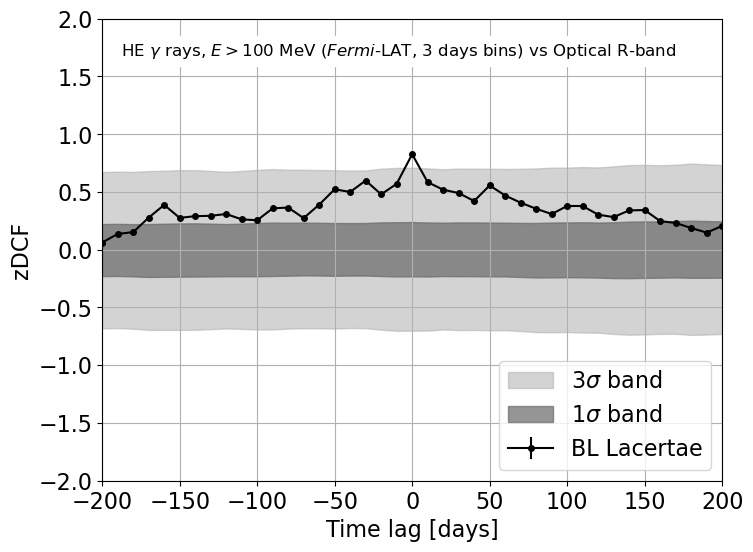

In [4]:
alpha = 0.5
label = "HE $\gamma$ rays, $E > 100$ MeV ($Fermi$-LAT, 3 days bins) vs Optical R-band"

fig, ax = plt.subplots(figsize = (8, 6))
ax.fill_between(delays_vec, zdcf_vec_mean - 3*zdcf_vec_std, zdcf_vec_mean + 3*zdcf_vec_std,
    interpolate = True, color = "darkgrey", alpha = alpha, label = "3$\sigma$ band")
ax.fill_between(delays_vec, zdcf_vec_mean - 1*zdcf_vec_std, zdcf_vec_mean + 1*zdcf_vec_std, 
    interpolate = True, color = "dimgray", alpha = alpha+0.2, label = "1$\sigma$ band")
ax.errorbar(
    true_zDCF[0], true_zDCF[2], yerr = true_zDCF[3],
    color = "black", ms = 4., marker = "o", capsize = 0.05, label = "BL Lacertae", ls = "solid"
)
ax.set_ylabel("zDCF")
ax.set_xlabel("Time lag [days]")
ax.set_ylim(bottom = -2., top = 2.)
ax.set_xlim(left = true_zDCF[0][0], right = true_zDCF[0][-1])
ax.text(0.03, 0.92, label, transform = ax.transAxes, fontsize = 12, bbox = {"facecolor":"white", "edgecolor":"white"})
ax.legend(loc = "lower right")
ax.grid()

os.system("mkdir -p ./Plots/")
fig.savefig("./Plots/BL_Lacertae_Gamma_Optical_correlation.png")

In [5]:
def process_fake_LCs_zDCF_at_given_delay (fake_zDCF_filename, nfiles, delay):
    zdcf_vec = np.array([])
    print ("Loading data from the %d files" % nfiles)
    for j in range(nfiles):
        data = np.loadtxt(fake_zDCF_filename % j, unpack = True)
        mask = np.abs(data[0] - delay) < 2
        zdcf_vec = np.append(zdcf_vec, data[2][mask])
    return zdcf_vec

zdcf_vec_zero_delay = process_fake_LCs_zDCF_at_given_delay(
    fake_zDCF_filename         = fake_zDCF_filename,
    nfiles                     = nfiles,
    delay = 0.
)

Loading data from the 1000 files


In [6]:
zdcf_true_zero_delay = true_zDCF[2][true_zDCF[0] == 0][0]
zdcf_true_zero_delay

0.826829

Probability of having a zDCF value larger than 8.2683e-01 is 2.0000e-03
Probability of having a zDCF value more distant to 0 from 8.2683e-01 is 8.1777e-03
Average = 0.004, Sigma = 0.235


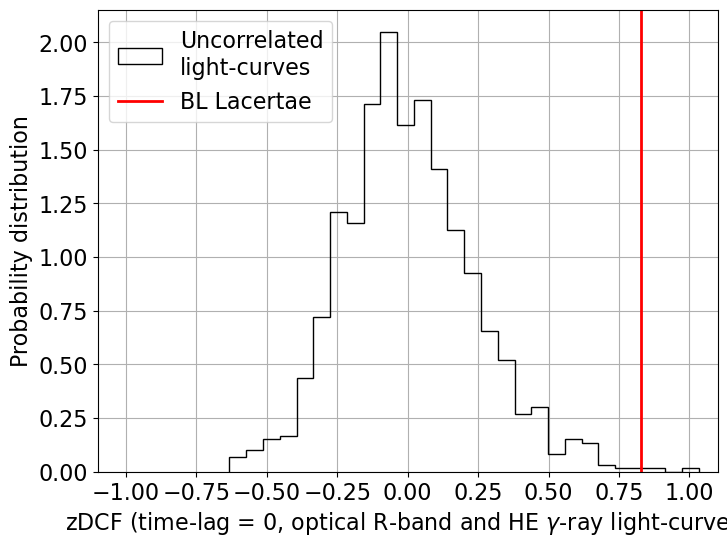

In [7]:
fig_h, ax_h = plt.subplots(figsize = (8, 6))
bins = 28
ax_h.hist(
    zdcf_vec_zero_delay, 
    bins = bins, 
    label = "Uncorrelated\nlight-curves",
    histtype = "step",
    density = True,
    color = "black"
)
ax_h.axvline(
    zdcf_true_zero_delay, 
    color = "red", 
    ls = "solid", 
    linewidth = 2, 
    label = "BL Lacertae"
)
p = np.count_nonzero(zdcf_vec_zero_delay > zdcf_true_zero_delay) / len(zdcf_vec_zero_delay)
p2 = 1.-erf( np.sqrt( ( ( zdcf_true_zero_delay - np.mean(zdcf_vec_zero_delay) ) / np.std(zdcf_vec_zero_delay) ) ) )
print ("Probability of having a zDCF value larger than %.4e is %.4e" % (zdcf_true_zero_delay, p))
print ("Probability of having a zDCF value more distant to 0 from %.4e is %.4e" % (zdcf_true_zero_delay, p2))
print ("Average = %.3f, Sigma = %.3f" % (np.mean(zdcf_vec_zero_delay), np.std(zdcf_vec_zero_delay)))

ax_h.set_xlabel("zDCF (time-lag = 0, optical R-band and HE $\gamma$-ray light-curves)")
ax_h.set_ylabel("Probability distribution")
ax_h.set_xlim(left = -1.1, right = 1.1)
ax_h.grid()
ax_h.legend(loc = "upper left");

os.system("mkdir -p ./Plots/")
fig.savefig("./Plots/BL_Lacertae_Gamma_Optical_correlation_at_zero_delay.png")

Important note when the correlation is high (close and above to $3\,\sigma$ level)
- **A number of simulations $N \gg 1000$ is necessary to estimate properly the confidence level of this correlation. Indeed, only 2 out of the 1000 pairs of simulated light-curves have a zDCF at zero delay larger than the observed one.**